In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Entrenamiento de Autoencoder Convolucional (CAE)



**Librerias**

In [6]:
import yaml
import os
import re
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [7]:
from model.cae import CAE

from utils import plot_paired_imgs
from utils import plot_sample_imgs
from utils import read_images

**Configuración**

In [8]:
with open('conf/user_conf.yaml', 'r') as f:
    conf = yaml.load(f)

In [9]:
patches_path = os.path.join(conf['data_path'], 'slides', 'patches')
models_path = os.path.join(conf['data_path'], 'models')
image_size = conf['wsi']['patch_size']

**Lectura de DataFrames**

In [10]:
slides_df = pd.read_csv(os.path.join(conf['data_path'], 'slides_metadata.csv'), sep='|')

In [11]:
slide_to_patch_columns = ['case_id', 'sample_id', 'slide_id', 'disease_type', 'sample_type', 
                          'percent_normal_cells', 'percent_stromal_cells', 'percent_tumor_cells', 'percent_tumor_nuclei']

## División en conjunto de Train y Test

El primer paso para entrenar un modelo es la división de los datos en los conjuntos de _train_ y _test_, de esta manera siempre se guarda una parte de los datos que el modelo 'no habrá visto' para evaluar su rendimiento. En este caso, esta división no se va a hacer aleatoria sobre el conjunto de *patches* si no que se hará la **división sobre el conjunto de slides**. El motivo es que dos *patches* de una misma imagen pueden ser muy similares al estar uno al lado de otro y por tanto la evaluación sería engañosa.

Además, puesto que se analizarán

In [37]:
slides_df = slides_df[slides_df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]

In [38]:
slides_df['sample_type'].value_counts(normalize=True)

Primary Tumor          0.907527
Solid Tissue Normal    0.092473
Name: sample_type, dtype: float64

In [39]:
slides_train, slides_test = train_test_split(slides_df, test_size=0.2, 
                                             stratify=slides_df['sample_type'], random_state=conf['seed']) 

In [40]:
slides_train['sample_type'].value_counts(normalize=True)

Primary Tumor          0.908602
Solid Tissue Normal    0.091398
Name: sample_type, dtype: float64

In [41]:
slides_test['sample_type'].value_counts(normalize=True)

Primary Tumor          0.903226
Solid Tissue Normal    0.096774
Name: sample_type, dtype: float64

## Patches DataFrames

__Slides to patches__

In [42]:
regex_slide_id = re.compile('.*(TCGA.*)_\d+_\d+\.png')

In [43]:
patches_df = []

for file_name in os.listdir(patches_path):
    
    if not file_name.endswith('.png'):
        continue
    
    slide_id = regex_slide_id.match(file_name).groups()[0]
    patches_df.append({'slide_id': slide_id, 'filename': file_name})
    
patches_df = pd.DataFrame(patches_df)

In [44]:
patches_df.head(5)

filename                 slide_id
0  TCGA-IB-7644-01A-01-BS1_001_009.png  TCGA-IB-7644-01A-01-BS1
1  TCGA-3A-A9IZ-01A-01-TS1_005_042.png  TCGA-3A-A9IZ-01A-01-TS1
2  TCGA-FZ-5921-01A-01-BS1_015_008.png  TCGA-FZ-5921-01A-01-BS1
3  TCGA-2J-AABT-01A-01-TS1_010_011.png  TCGA-2J-AABT-01A-01-TS1
4  TCGA-3A-A9IZ-01A-01-TS1_003_013.png  TCGA-3A-A9IZ-01A-01-TS1

In [45]:
training_patches_df = patches_df.merge(slides_train[slide_to_patch_columns], on='slide_id').sample(frac=1, random_state=conf['seed'])
test_patches_df = patches_df.merge(slides_test[slide_to_patch_columns], on='slide_id').sample(frac=1, random_state=conf['seed'])

In [46]:
training_patches_tumor_df = training_patches_df[training_patches_df['sample_type'] == 'Primary Tumor']
training_patches_normal_df = training_patches_df[training_patches_df['sample_type'] == 'Solid Tissue Normal']

test_patches_tumor_df = test_patches_df[test_patches_df['sample_type'] == 'Primary Tumor']
test_patches_normal_df = test_patches_df[test_patches_df['sample_type'] == 'Solid Tissue Normal']

In [47]:
training_patches_tumor_df.head(3)

filename                 slide_id  \
7689   TCGA-HV-A7OP-01A-01-TS1_006_039.png  TCGA-HV-A7OP-01A-01-TS1   
10027  TCGA-HZ-8637-01A-01-TS1_011_020.png  TCGA-HZ-8637-01A-01-TS1   
11674  TCGA-XD-AAUL-01A-02-TSB_014_005.png  TCGA-XD-AAUL-01A-02-TSB   

            case_id         sample_id                  disease_type  \
7689   TCGA-HV-A7OP  TCGA-HV-A7OP-01A  Ductal and Lobular Neoplasms   
10027  TCGA-HZ-8637  TCGA-HZ-8637-01A  Ductal and Lobular Neoplasms   
11674  TCGA-XD-AAUL  TCGA-XD-AAUL-01A  Ductal and Lobular Neoplasms   

         sample_type  percent_normal_cells  percent_stromal_cells  \
7689   Primary Tumor                   0.0                   25.0   
10027  Primary Tumor                  20.0                    8.0   
11674  Primary Tumor                  15.0                   25.0   

       percent_tumor_cells  percent_tumor_nuclei  
7689                  70.0                  70.0  
10027                 70.0                  55.0  
11674                 60.0                  60.0

In [48]:
training_patches_normal_df.head(3)

filename                 slide_id  \
6103   TCGA-FZ-5920-11A-01-TS1_016_008.png  TCGA-FZ-5920-11A-01-TS1   
12250  TCGA-FB-AAPZ-11A-01-TSA_014_022.png  TCGA-FB-AAPZ-11A-01-TSA   
16672  TCGA-FB-AAPY-11A-01-TSA_005_008.png  TCGA-FB-AAPY-11A-01-TSA   

            case_id         sample_id                  disease_type  \
6103   TCGA-FZ-5920  TCGA-FZ-5920-11A  Ductal and Lobular Neoplasms   
12250  TCGA-FB-AAPZ  TCGA-FB-AAPZ-11A  Ductal and Lobular Neoplasms   
16672  TCGA-FB-AAPY  TCGA-FB-AAPY-11A  Ductal and Lobular Neoplasms   

               sample_type  percent_normal_cells  percent_stromal_cells  \
6103   Solid Tissue Normal                   NaN                    NaN   
12250  Solid Tissue Normal                  60.0                   40.0   
16672  Solid Tissue Normal                  60.0                   40.0   

       percent_tumor_cells  percent_tumor_nuclei  
6103                   NaN                   NaN  
12250                  0.0                   0.0  
16672                  0.0                   0.0

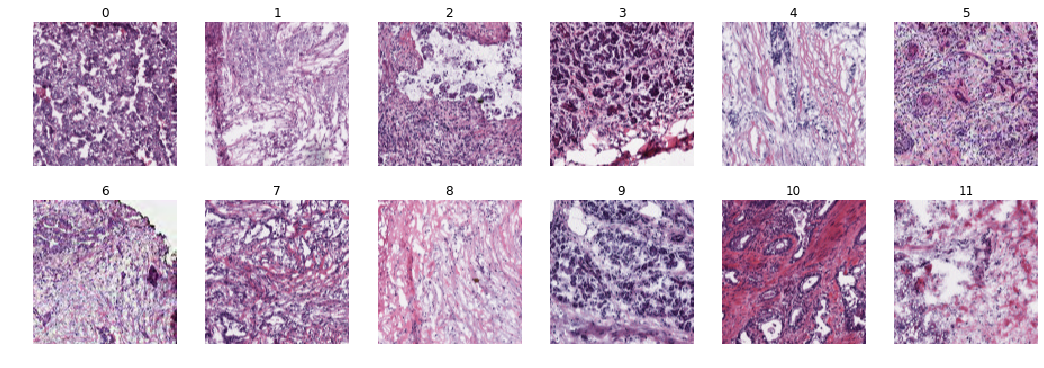

In [49]:
images_tumor_sample = read_images(training_patches_tumor_df['filename'].iloc[:20], patches_path)
plot_sample_imgs(images_tumor_sample, n_rows=2, n_cols=6, shuffle=False)

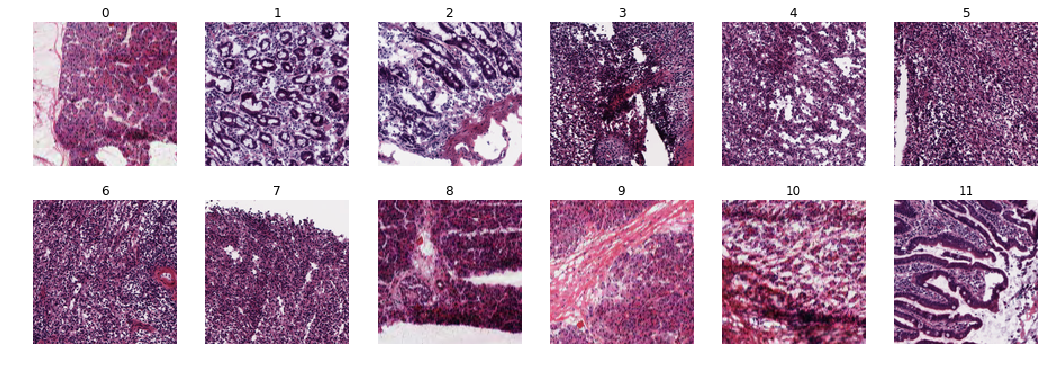

In [50]:
images_normal_sample = read_images(training_patches_normal_df['filename'].iloc[:20], patches_path)
plot_sample_imgs(images_normal_sample, n_rows=2, n_cols=6, shuffle=False)

__Save__

In [51]:
training_patches_df.to_csv(os.path.join(conf['data_path'], 'train.csv'), sep='|', index=False)
test_patches_df.to_csv(os.path.join(conf['data_path'], 'test.csv'), sep='|', index=False)

## Train model

__Image generators__

In [23]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(training_patches_df, directory=patches_path, x_col='filename', 
                                                    target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                    subset='training', seed=conf['seed'])

validation_generator = train_datagen.flow_from_dataframe(training_patches_df, directory=patches_path, x_col='filename', 
                                                         target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                         subset='validation', seed=conf['seed'])

Found 47159 images.
Found 11789 images.


In [24]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_dataframe(test_patches_df, directory=patches_path, x_col='filename', 
                                                  target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                  seed=conf['seed'])

Found 13317 images.


__Train Model__

In [52]:
# initialize ConvAutoEncoder model
cae = CAE(input_shape=(image_size, image_size, 3), latent_features=256, filters=[8,16,32],
          path=os.path.join(models_path, 'model_test_2.5'))

In [53]:
tb = TensorBoard(log_dir='../logs/model_test_2.5', 
                 write_grads=True, write_images=True, histogram_freq=0)

In [55]:
EPOCHS = 4

cae.model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        steps_per_epoch = len(train_generator),
                        validation_steps = len(validation_generator),
                        epochs = EPOCHS, 
                        callbacks = [tb],
                        workers=8)

Epoch 1/4
1474/1474 [==============================] - 133s 90ms/step - loss: 0.0246 - val_loss: 0.0212
Epoch 2/4
1474/1474 [==============================] - 131s 89ms/step - loss: 0.0209 - val_loss: 0.0206
Epoch 3/4
1474/1474 [==============================] - 129s 88ms/step - loss: 0.0203 - val_loss: 0.0202
Epoch 4/4
1474/1474 [==============================] - 128s 87ms/step - loss: 0.0200 - val_loss: 0.0199


In [56]:
cae.save()

__Evaluation__

In [57]:
cae.model.evaluate_generator(test_generator, steps=len(test_generator))

0.01979166984484254

__Output examples__

In [58]:
X_train = next(train_generator)[0]
X_train_out = cae.model.predict(X_train)

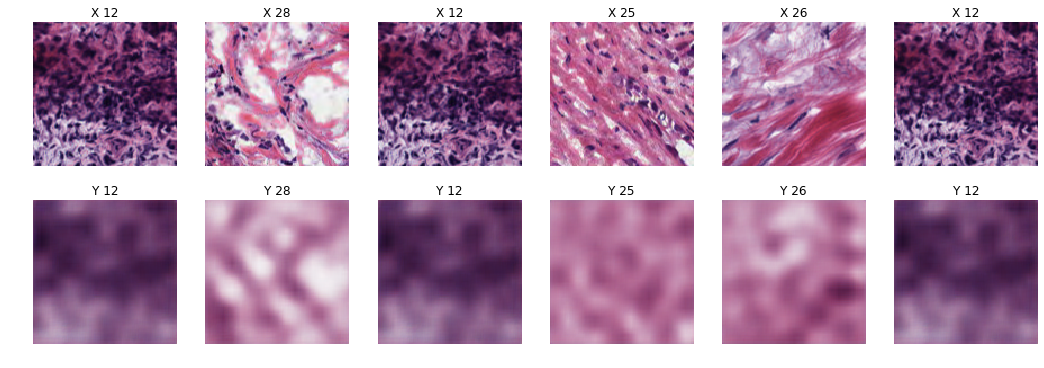

In [59]:
plot_paired_imgs(X_train, X_train_out, N=6)

In [60]:
X_test = next(test_generator)[0]
X_test_out = cae.model.predict(X_test)

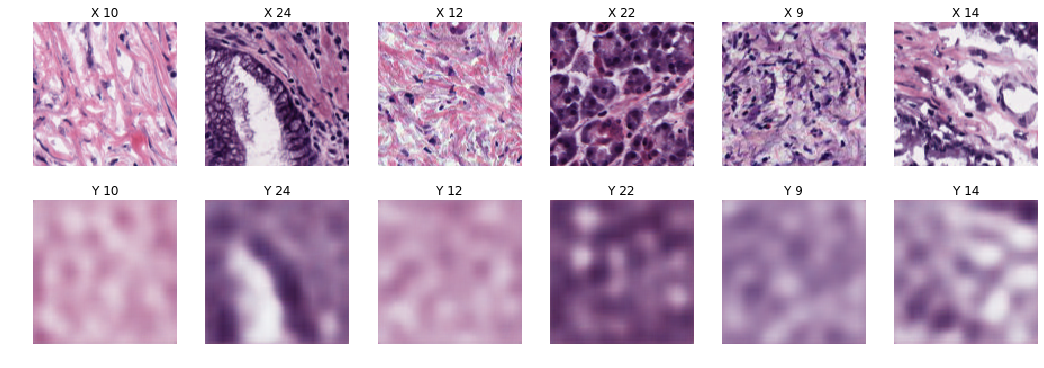

In [61]:
plot_paired_imgs(X_test, X_test_out, N=6)

__Multiple models__

In [62]:
models = [{'id': 1, 'filters': [8,16,32], 'latent_features': 256},
          {'id': 2, 'filters': [8,16,32], 'latent_features': 512},
          {'id': 3, 'filters': [8,16,32], 'latent_features': 1024},
          {'id': 4, 'filters': [8,16,32,64], 'latent_features': 512}]

In [ ]:
EPOCHS = 30

for model in models:
    
    print()
    
    cae = CAE(input_shape=(image_size, image_size, 3), 
              latent_features=model['latent_features'], 
              filters=model['filters'],
              path=os.path.join(models_path, 'model_{}'.format(model['id'])))
    
    
    tb = TensorBoard(log_dir='../logs/model_{}'.format(model['id']), 
                 write_grads=True, write_images=True, histogram_freq=0)
    
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    
    cae.model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        steps_per_epoch = len(train_generator),
                        validation_steps = len(validation_generator),
                        epochs = EPOCHS, 
                        callbacks = [tb, es],
                        workers = 12)
    
    cae.save()

## Train Tumor/Normal Models

__Balance tranining data__

In [ ]:
training_patches_tumor_df = training_patches_tumor_df.sample(n=len(training_patches_normal_df), 
                                                             random_state=SEED)

test_patches_tumor_df = training_patches_tumor_df.sample(n=len(test_patches_normal_df), 
                                                         random_state=SEED)

In [ ]:
len(training_patches_tumor_df)

In [ ]:
len(training_patches_normal_df)

__Image generators__

Tumor

In [ ]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)

train_tumor_generator = train_datagen.flow_from_dataframe(training_patches_tumor_df, directory=patches_path, x_col='filename', 
                                                          target_size=(image_size, image_size), color_mode='rgb', class_mode='input',
                                                          subset='training', seed=conf['seed'])

validation_tumor_generator = train_datagen.flow_from_dataframe(training_patches_tumor_df, directory=patches_path, x_col='filename', 
                                                               target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                               subset='validation', seed=conf['seed'])

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_tumor_generator = test_datagen.flow_from_dataframe(test_patches_tumor_df, directory=patches_path, x_col='filename', 
                                                        target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                        seed=cong['seed'])

Normal

In [ ]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)

train_normal_generator = train_datagen.flow_from_dataframe(training_patches_normal_df, directory=patches_path, x_col='filename', 
                                                           target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                           subset='training', seed=conf['seed'])

validation_normal_generator = train_datagen.flow_from_dataframe(training_patches_normal_df, directory=patches_path, x_col='filename', 
                                                                target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                                subset='validation', seed=conf['seed'])

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_normal_generator = test_datagen.flow_from_dataframe(test_patches_normal_df, directory=patches_path, x_col='filename', 
                                                         target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                         seed=conf['seed'])

__Train Models__

In [394]:
EPOCHS = 50

In [395]:
# initialize ConvAutoEncoder model
cae_tumor = CAE(input_shape=(image_size, image_size, 3), latent_features=None, filters=[8,16,32],
          path=os.path.join(models_path, 'model_tumor'))

In [396]:
cae_normal = CAE(input_shape=(image_size, image_size, 3), latent_features=None, filters=[8,16,32],
                 path=os.path.join(models_path, 'model_normal'))

In [397]:
tb = TensorBoard(log_dir='../logs/model_tumor, 
                 write_grads=True, write_images=True, histogram_freq=0)

cae_tumor.model.fit_generator(generator = train_tumor_generator, 
                              validation_data = validation_tumor_generator,
                              steps_per_epoch = len(train_tumor_generator),
                              validation_steps = len(validation_tumor_generator),
                              epochs = EPOCHS, 
                              callbacks = [tb])

cae_tumor.save()

Epoch 1/50
156/156 [==============================] - 9s 58ms/step - loss: 0.0294 - val_loss: 0.0211
Epoch 2/50
156/156 [==============================] - 8s 54ms/step - loss: 0.0154 - val_loss: 0.0133
Epoch 3/50
156/156 [==============================] - 8s 53ms/step - loss: 0.0119 - val_loss: 0.0113
Epoch 4/50
156/156 [==============================] - 8s 52ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 5/50
156/156 [==============================] - 8s 52ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 6/50
156/156 [==============================] - 8s 52ms/step - loss: 0.0096 - val_loss: 0.0099
Epoch 7/50
156/156 [==============================] - 8s 52ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 8/50
156/156 [==============================] - 8s 52ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 9/50
156/156 [==============================] - 8s 53ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/50
156/156 [==============================] - 8s 54ms/step - loss: 0.0086 - val_lo

In [398]:
tb = TensorBoard(log_dir='../logs/model_normal', 
                 write_grads=True, write_images=True, histogram_freq=0)

cae_normal.model.fit_generator(generator = train_normal_generator, 
                              validation_data = validation_normal_generator,
                              steps_per_epoch = len(train_normal_generator),
                              validation_steps = len(validation_normal_generator),
                              epochs = EPOCHS, 
                              callbacks = [tb])

cae_normal.save()

Epoch 1/50
156/156 [==============================] - 9s 60ms/step - loss: 0.0232 - val_loss: 0.0150
Epoch 2/50
156/156 [==============================] - 8s 54ms/step - loss: 0.0136 - val_loss: 0.0128
Epoch 3/50
156/156 [==============================] - 8s 53ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 4/50
156/156 [==============================] - 8s 52ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 5/50
156/156 [==============================] - 8s 52ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 6/50
156/156 [==============================] - 8s 53ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 7/50
156/156 [==============================] - 8s 53ms/step - loss: 0.0103 - val_loss: 0.0104
Epoch 8/50
156/156 [==============================] - 8s 54ms/step - loss: 0.0100 - val_loss: 0.0105
Epoch 9/50
156/156 [==============================] - 8s 54ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 10/50
156/156 [==============================] - 8s 54ms/step - loss: 0.0096 - val_lo

__Evaluation__

Tumor

In [399]:
cae_tumor.model.evaluate_generator(test_tumor_generator, steps=len(test_tumor_generator))

0.005762119347659441

In [400]:
cae_tumor.model.evaluate_generator(test_normal_generator, steps=len(test_normal_generator))

0.006109444917791607

Normal

In [401]:
cae_normal.model.evaluate_generator(test_tumor_generator, steps=len(test_tumor_generator))

0.006147554093338307

In [402]:
cae_normal.model.evaluate_generator(test_normal_generator, steps=len(test_normal_generator))

0.006358175396926156

__Examples__

Tumor model - Tumor data

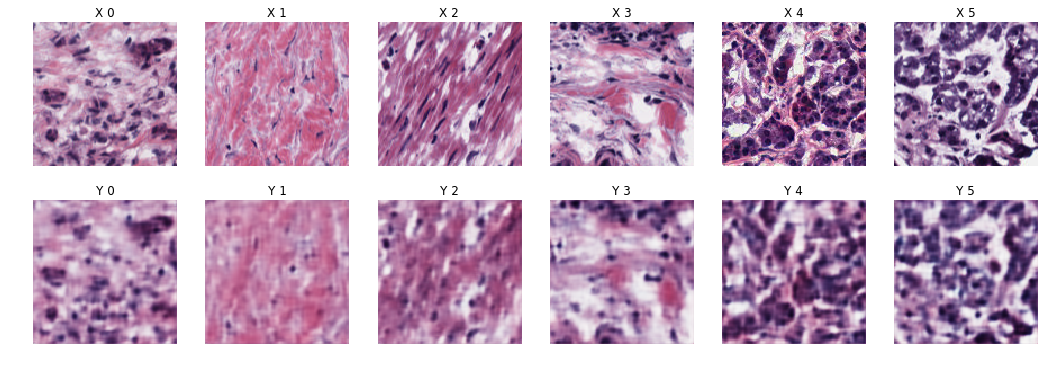

In [415]:
X_test = next(test_tumor_generator)[0]
X_test_out = cae_tumor.model.predict(X_test)
plot_paired_imgs(X_test, X_test_out, N=6)

Tumor model - Normal data

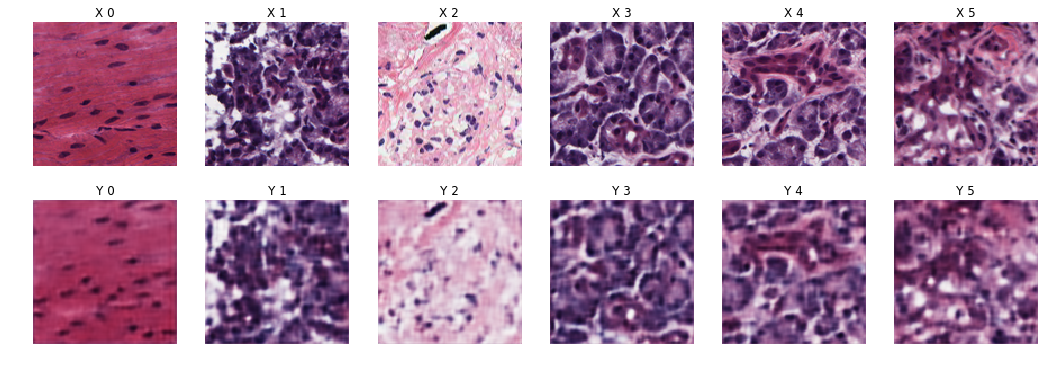

In [414]:
X_test = next(test_normal_generator)[0]
X_test_out = cae_tumor.model.predict(X_test)
plot_paired_imgs(X_test, X_test_out, N=6)

Normal model - Normal data

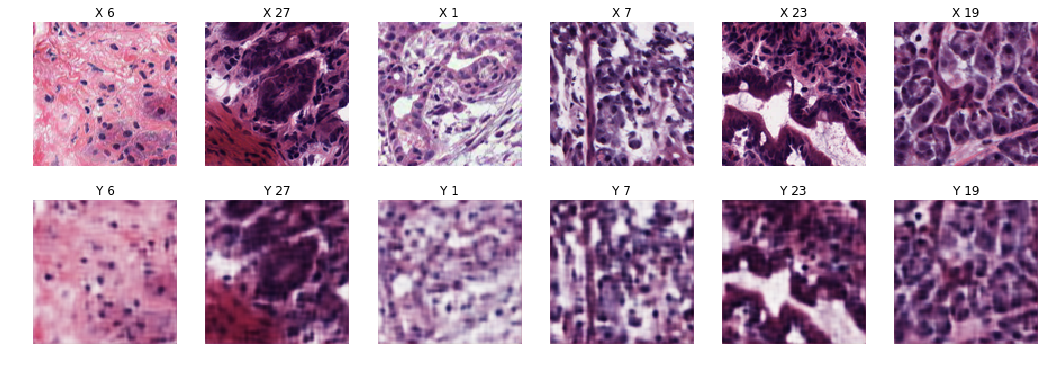

In [416]:
X_test = next(test_normal_generator)[0]
X_test_out = cae_normal.model.predict(X_test)
plot_paired_imgs(X_test, X_test_out, N=6)

Normal model - Tumor data

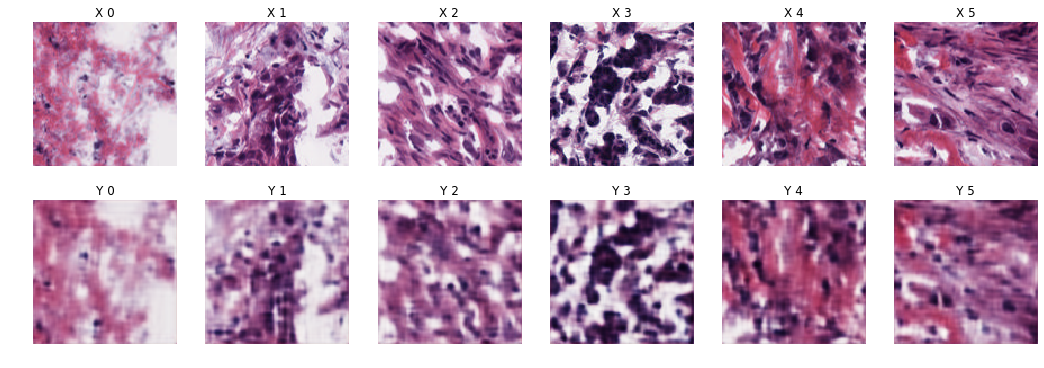

In [417]:
X_test = next(test_tumor_generator)[0]
X_test_out = cae_normal.model.predict(X_test)
plot_paired_imgs(X_test, X_test_out, N=6, shuffle=False)